---
title: "Ordering categories"
author: "Damien Martin"
date: "2024-10-20 9:00"
categories: [data-vis, plotnine, gallery, categorical]
image: "image.jpg"
description: "Categories in legends are (by default) ordered alphabetically. To customize the ordering, you should be using pd.Categories"
---

# Problem

The default way that non-numeric data is ordered in plot-nine is lexigraphical, rather than by meaningful order.

For example, if you are working for Toyota, you might want the Toyota cars to be listed at the top of the legends. By default, it will to listed after Audi, Chevy, Ford, Mitsubishi, and Tesla.

# Solution
Replace the strings with a categorical data type. For the car example above:
```python
df['manufacturer'] = pd.Categorical(
    df['manufacturer'],
    categories = ["Toyota", ....],  # Order the others how you would like
    ordered=True
)
```
Then legends will respect the order of the categories, rather than the lexigraphical ordering.

# Example

Let's look at the monthly meat production built into plotnine. We will first convert it from wide form to long form.

In [1]:
import plotnine as p9
from plotnine.data import meat as meat_source
import pandas as pd

meat = meat_source.melt('date', var_name='meat_type', value_name='weight_M_lbs').dropna()
meat

,date,meat_type,weight_M_lbs
0,1944-01-01,beef,751.0
1,1944-02-01,beef,713.0
2,1944-03-01,beef,741.0
3,1944-04-01,beef,650.0
4,1944-05-01,beef,681.0
...,...,...,...
6715,2023-08-01,turkey,489.2
6716,2023-09-01,turkey,431.2
6717,2023-10-01,turkey,500.3
6718,2023-11-01,turkey,449.2


Let's start by making a simple plot:

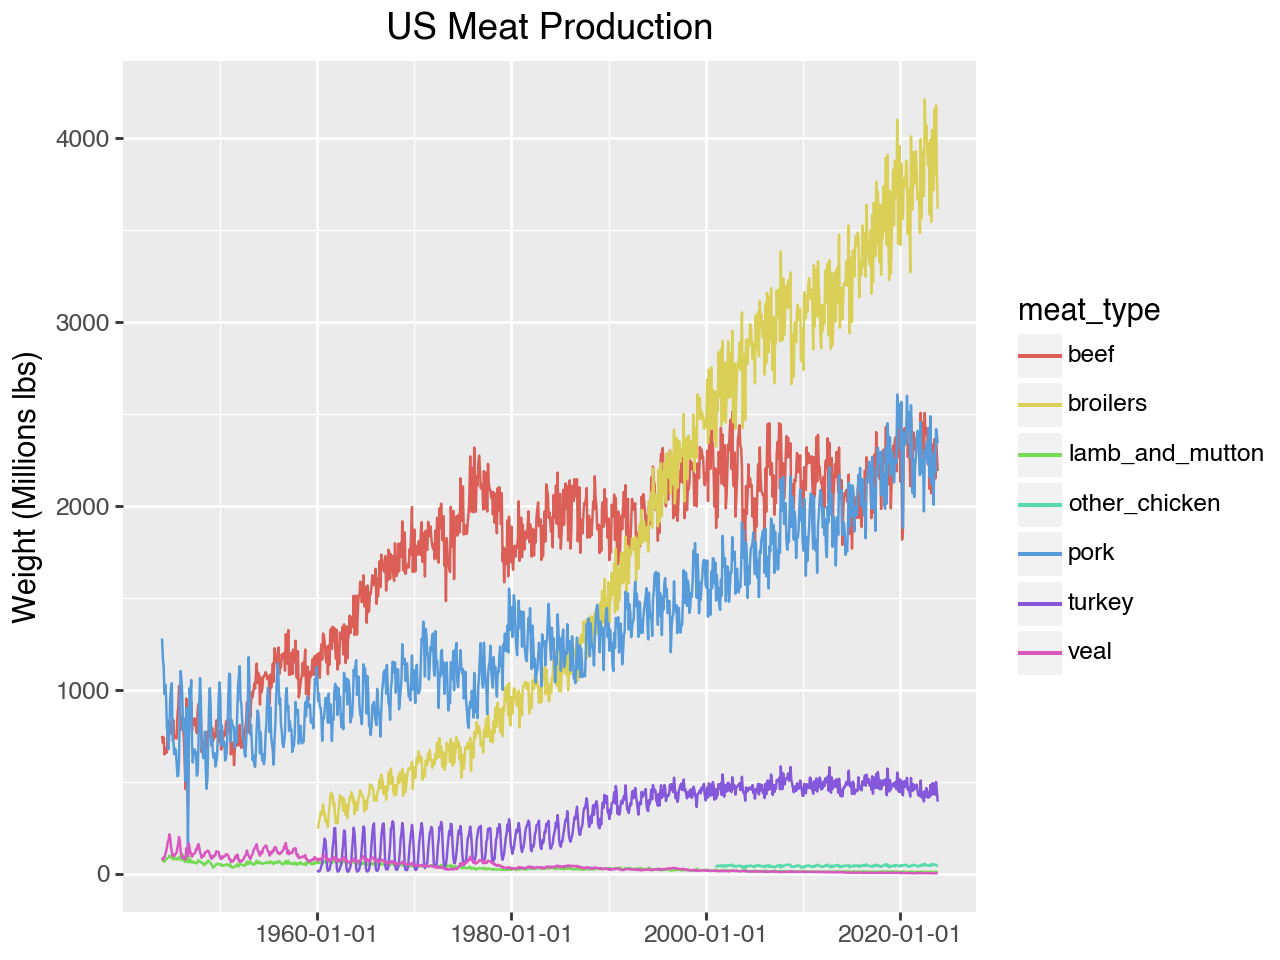

In [2]:
(
    p9.ggplot(meat, p9.aes(x='date', y='weight_M_lbs', color='meat_type'))
    + p9.geom_line()
    + p9.labs(title="US Meat Production", x="", y="Weight (Millions lbs)")
)

Some things we would like to clean up:

| Problem | Solution |
|---|---|
| Seasonal fluctuations | Use a rolling average |
| Top meats (broilers, beed, pork, turkey) are on positions 1, 2, 4, 5 on list | Use categoricals instead | 
| Other_chicken is similar to color to lamb_and_mutton | Combine less popular categories | 

The rolling average is a relatively easy one:

In [3]:
meat['weight_rolling'] = (
    meat
    .sort_values('date')
    .groupby('meat_type')['weight_M_lbs']
    .transform(lambda x: x.rolling(12).mean())
)

/Users/damienmartin/anaconda3/envs/blog/lib/python3.12/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 11 rows containing missing values.


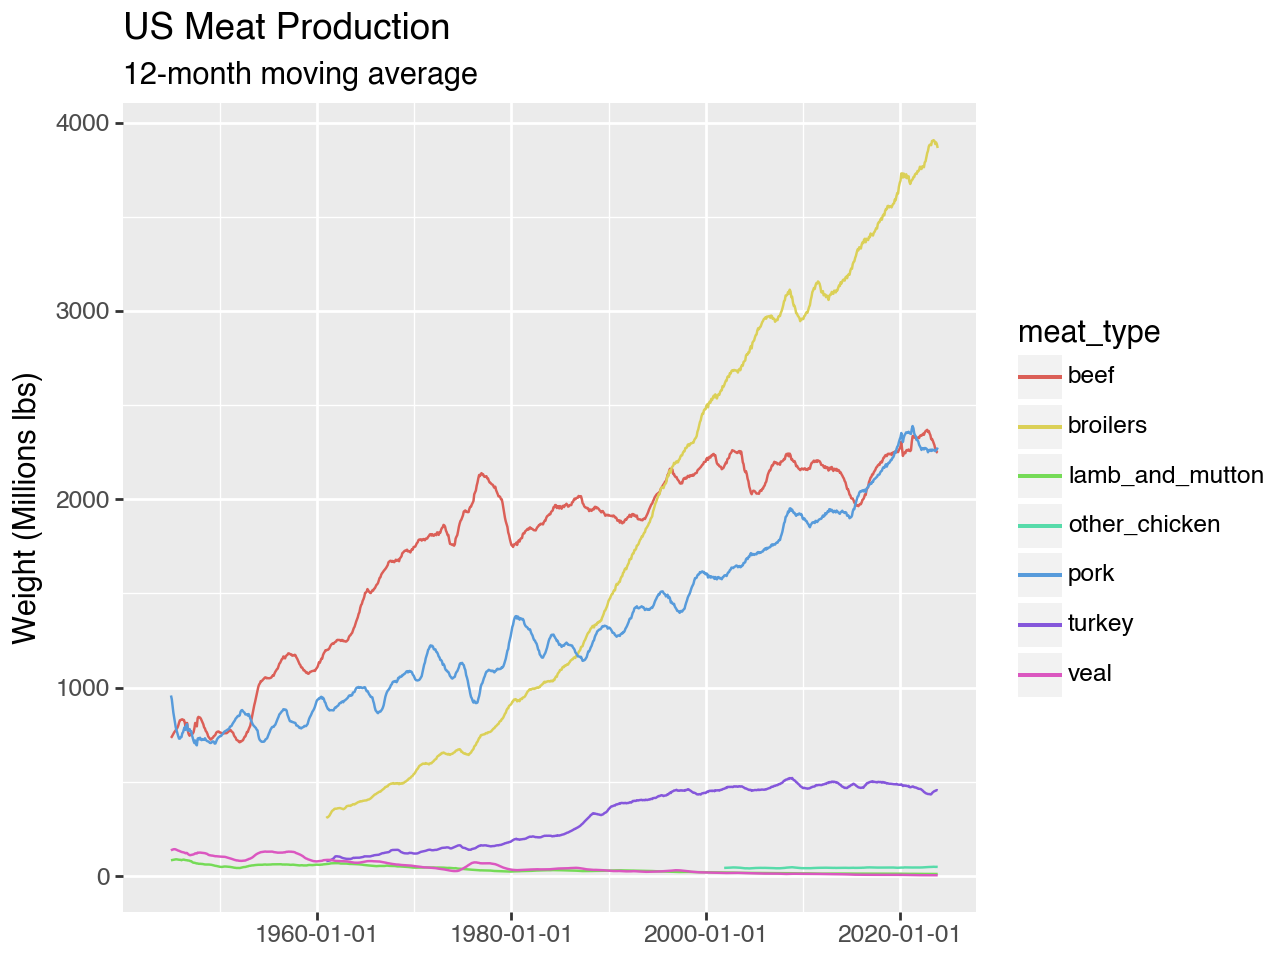

In [4]:
(
    p9.ggplot(meat, p9.aes(x='date', y='weight_rolling', color='meat_type'))
    + p9.geom_line()
    + p9.labs(
        title="US Meat Production", 
        subtitle="12-month moving average", 
        x="", 
        y="Weight (Millions lbs)"
    )
)

Now let's lump the other categories below the top 5 into "other". We will redo our moving averages after combining (otherwise we can get weird zero issues as we combine `NA` and ordinary values)

In [5]:
meat['meat_type'] = (
    meat['meat_type']
    .apply(lambda meat_type: meat_type if meat_type in {'beef', 'pork', 'broilers', 'turkey'} else 'other')
)
meat_simple = meat.groupby(['date', 'meat_type'])['weight_M_lbs'].sum().reset_index()
meat_simple['weight_rolling'] = (
    meat_simple
    .sort_values('date')
    .groupby('meat_type')['weight_M_lbs']
    .transform(lambda x: x.rolling(12).mean())
)
meat_simple = meat_simple.dropna()

This simplifies the number of lines we have to deal with

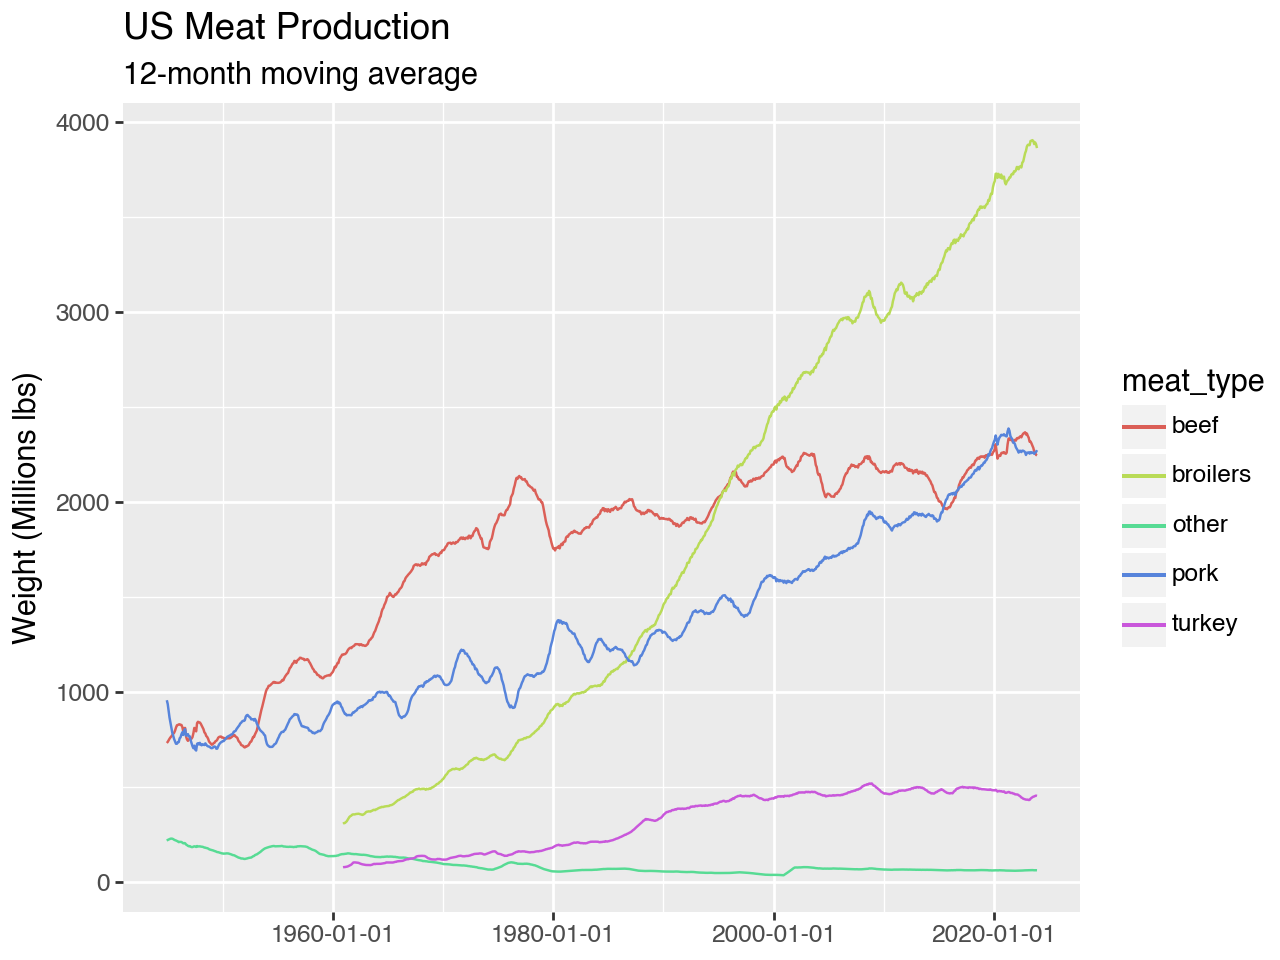

In [6]:
(
    p9.ggplot(meat_simple, p9.aes(x='date', y='weight_rolling', color='meat_type'))
    + p9.geom_line()
    + p9.labs(
        title="US Meat Production", 
        subtitle="12-month moving average", 
        x="", 
        y="Weight (Millions lbs)"
    )
)

Now let's deal with the order on the legend: "other" should be at the bottom of the list. Let's order by the popularity in 2000:
* Broilers
* Beef
* Pork
* Turkey
* Other

Let's do it manually first:

In [7]:
meat_simple['meat_type'] = pd.Categorical(
    meat_simple['meat_type'], 
    categories=['broilers', 'beef', 'pork', 'turkey','other'], 
    ordered=True
)

Using the _same code_ as before, we now have

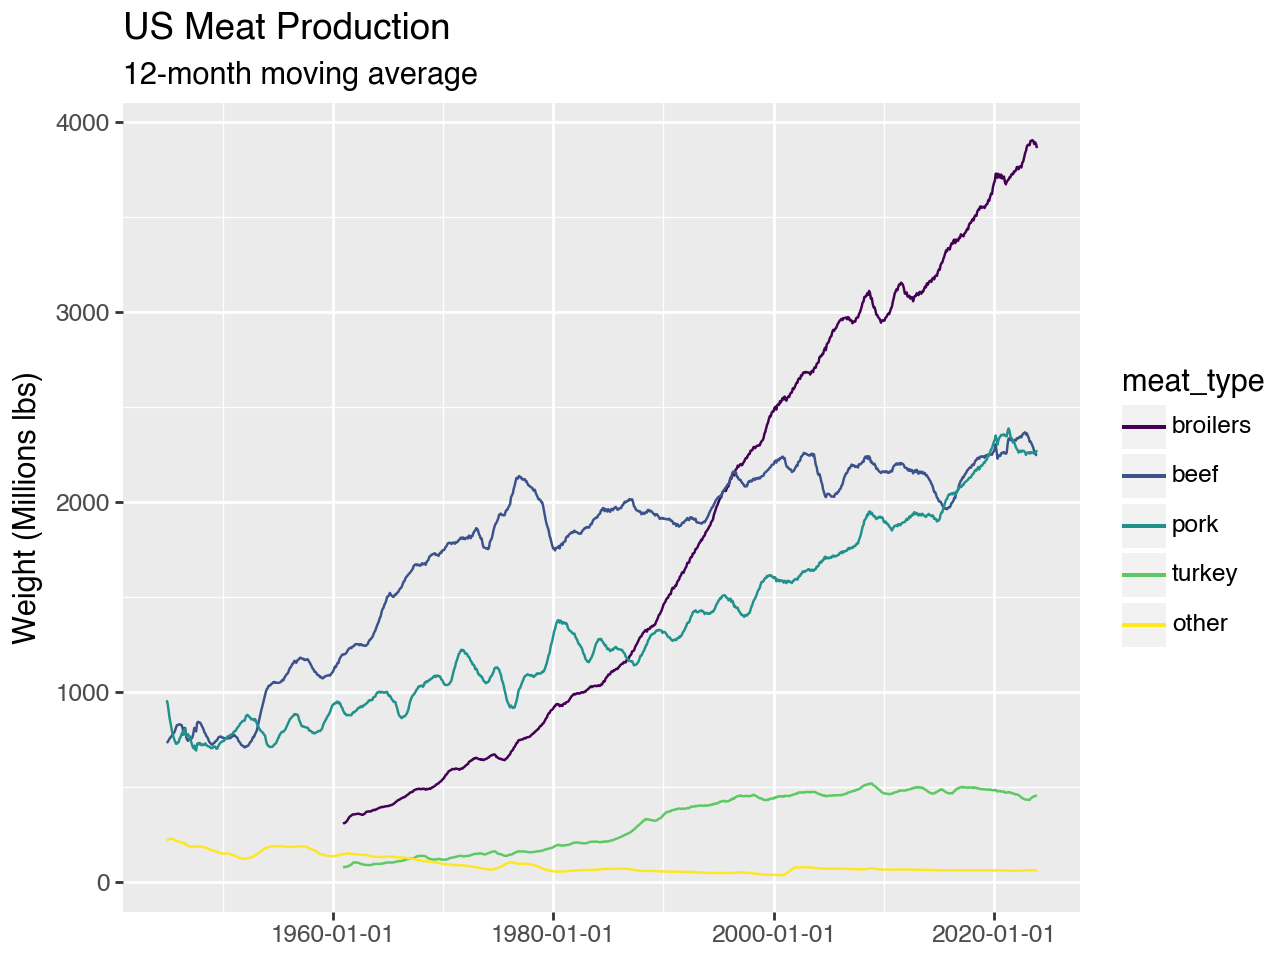

In [8]:
(
    p9.ggplot(meat_simple, p9.aes(x='date', y='weight_rolling', color='meat_type'))
    + p9.geom_line()
    + p9.labs(
        title="US Meat Production", 
        subtitle="12-month moving average", 
        x="", 
        y="Weight (Millions lbs)"
    )
)

We can fix the colors in just a moment. Let's address the conversion, which was done manually here. A less error-prone way of doing it would be to do exactly as we did -- decide that the order was going to be determined by the values on a particular date. We can then do the order programmatically (this was a tip taken from this [lovely plot](https://nrennie.rbind.io/blog/plotnine-annotated-area-chart/))

In [9]:
# reset
meat_simple['meat_type'] = meat_simple['meat_type'].astype('str')

ordering = meat_simple[meat_simple['date'] == '2000-01-01'].sort_values(
    by='weight_rolling', ascending=False)['meat_type']
meat_simple['meat_type'] = pd.Categorical(
    meat_simple['meat_type'],
    categories=ordering,
    ordered=True
)

Next, let's pick a better palette, and rename the categories. We will also
- move the legend inside the plot
- eliminate the extra space around along the axes
- eliminate the background shading

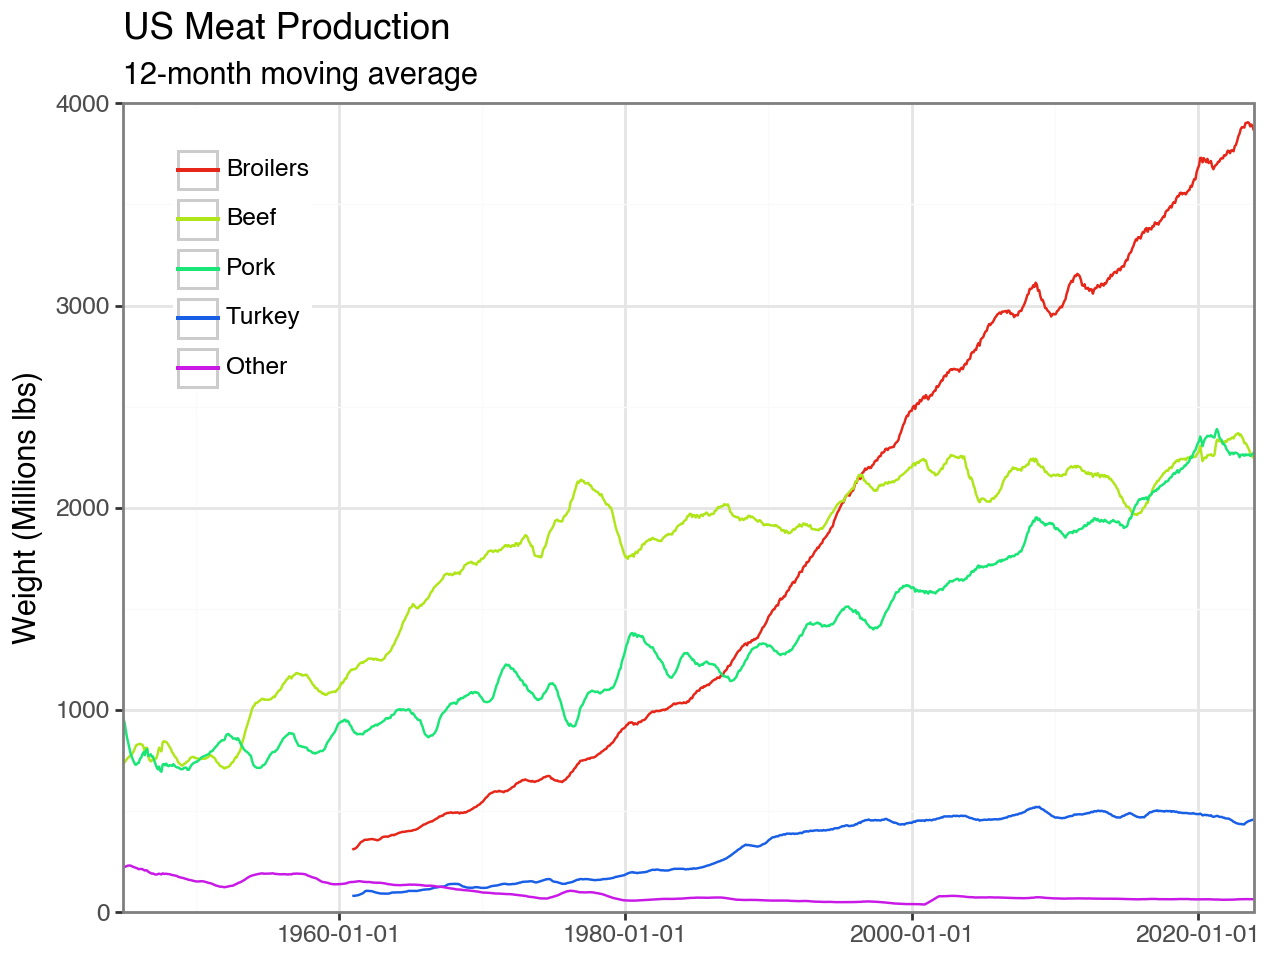

In [10]:
(
    p9.ggplot(meat_simple, p9.aes(x='date', y='weight_rolling', color='meat_type'))
    + p9.geom_line()
    + p9.labs(
        title="US Meat Production", 
        subtitle="12-month moving average", 
        x="", 
        y="Weight (Millions lbs)"
    )
    + p9.scale_colour_discrete(
        s=0.8,
        l=0.5,
        labels=lambda values: [v.title() for v in values],
        name=" ",  # Have to have a space, using an empty string will be ignored
    )
    + p9.scale_y_continuous(limits=(0, 4000), expand=(0,0))
    + p9.scale_x_date(expand=(0,0))
    + p9.theme_bw()
    + p9.theme(legend_position=(0.05, 0.99))
)

We can also eliminate the outside frame

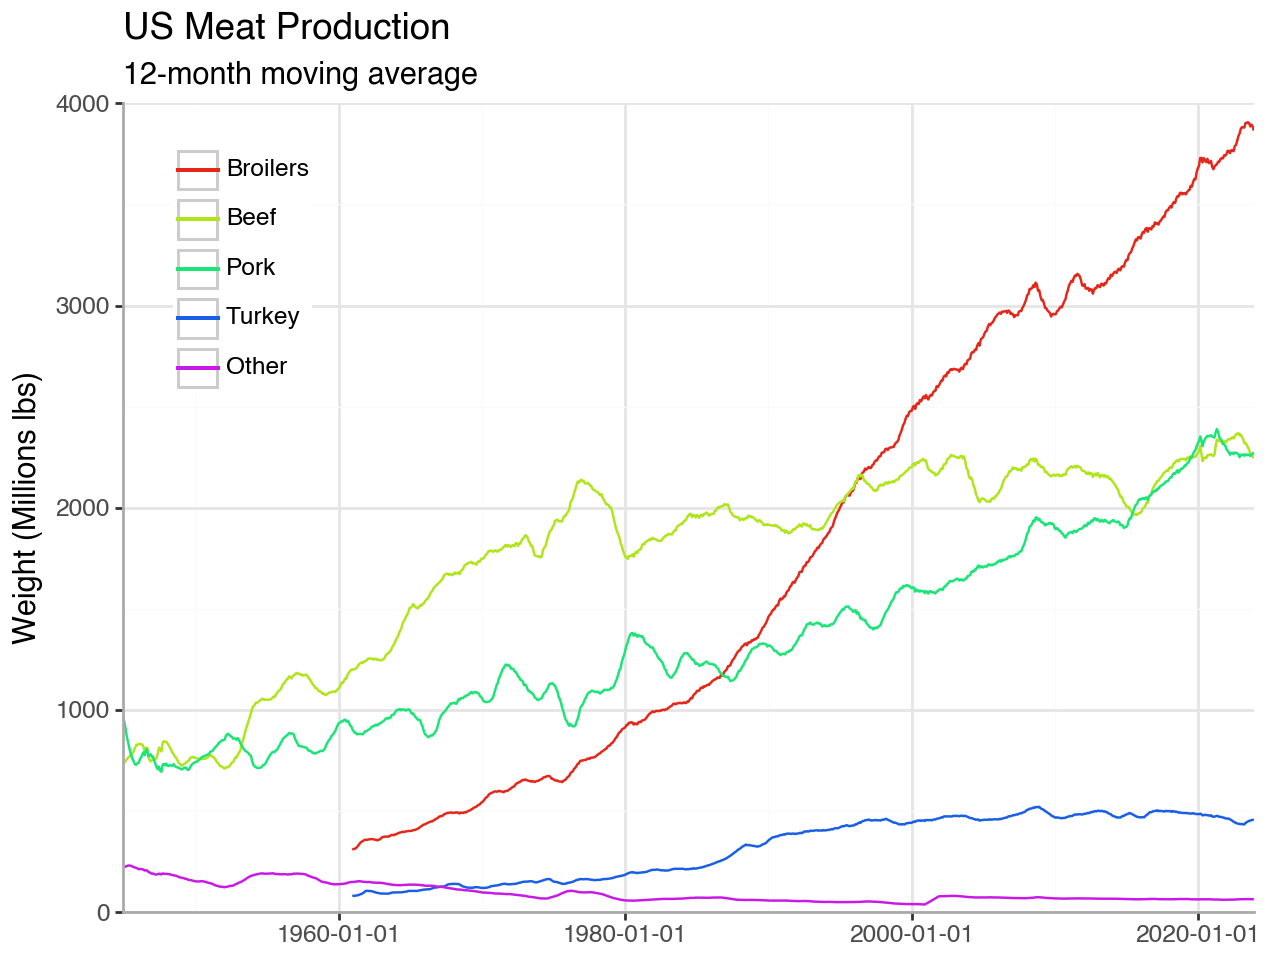

In [11]:
(
    p9.ggplot(meat_simple, p9.aes(x='date', y='weight_rolling', color='meat_type'))
    + p9.geom_line()
    + p9.labs(
        title="US Meat Production", 
        subtitle="12-month moving average", 
        x="", 
        y="Weight (Millions lbs)"
    )
    + p9.scale_colour_discrete(
        s=0.8,
        l=0.5,
        labels=lambda values: [v.title() for v in values],
        name=" ",  # Have to have a space, using an empty string will be ignored
    )
    + p9.scale_y_continuous(limits=(0, 4000), expand=(0,0))
    + p9.scale_x_date(expand=(0,0))
    + p9.theme_bw()
    + p9.theme(
        legend_position=(0.05, 0.99), 
        panel_border=p9.element_blank(),
        axis_line=p9.element_line(size=1, color='#AAAAAA')
    )
)

We could also forgo the legend and label the lines directly

In [12]:
line_label = meat_simple[meat_simple.date=='2005-01-01'].copy().assign(
    meat_label=lambda x: x['meat_type'].str.title()
)
line_label

,date,meat_type,weight_M_lbs,weight_rolling,meat_label
3276,2005-01-01,beef,1915.6,2044.800000,Beef
3277,2005-01-01,broilers,2884.1,2843.658333,Broilers
3278,2005-01-01,other,66.5,71.750000,Other
3279,2005-01-01,pork,1704.8,1704.650000,Pork
3280,2005-01-01,turkey,455.3,455.791667,Turkey


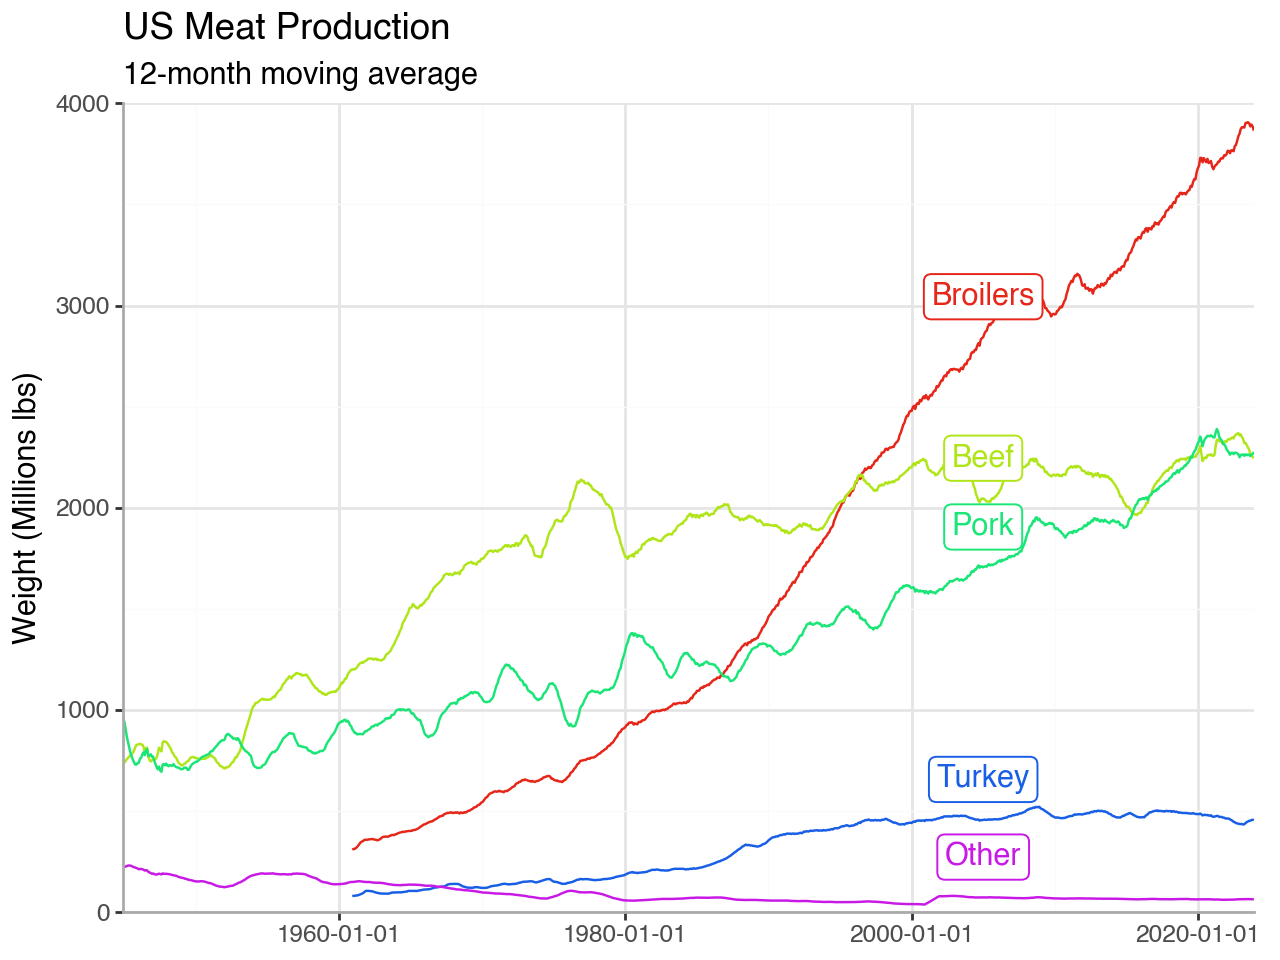

In [13]:
(
    p9.ggplot(meat_simple, p9.aes(x='date', y='weight_rolling', color='meat_type'))
    + p9.geom_line()
    + p9.labs(
        title="US Meat Production", 
        subtitle="12-month moving average", 
        x="", 
        y="Weight (Millions lbs)"
    )
    + p9.scale_colour_discrete(
        s=0.8,
        l=0.5,
        guide=None
        
    )
    + p9.geom_label(
        data=line_label,
        mapping=p9.aes(label='meat_label'),
        nudge_y=200
    )
    + p9.scale_y_continuous(limits=(0, 4000), expand=(0,0))
    + p9.scale_x_date(expand=(0,0))
    + p9.theme_bw()
    + p9.theme(
        panel_border=p9.element_blank(), 
        axis_line=p9.element_line(size=1, color='#AAAAAA'),
    )
)

If you don't like the label and line overlap, you can manually manipulate the label frame. Unfortunately, the `nudge_y` does not get passed in from the mapping.

In [14]:
# This is the same as before
line_label = meat_simple[meat_simple.date=='2005-01-01'].copy().assign(
    meat_label=lambda x: x['meat_type'].str.title()
)
# Move away from the lines / each other, taking the nudge_y into account
# This is a "guess and check" for finalized figures
adjustments = {'pork': -450, 'broilers': 250, 'beef': 200}
for meat, shift in adjustments.items():
    line_label.loc[line_label.meat_type==meat, 'weight_rolling'] += shift 

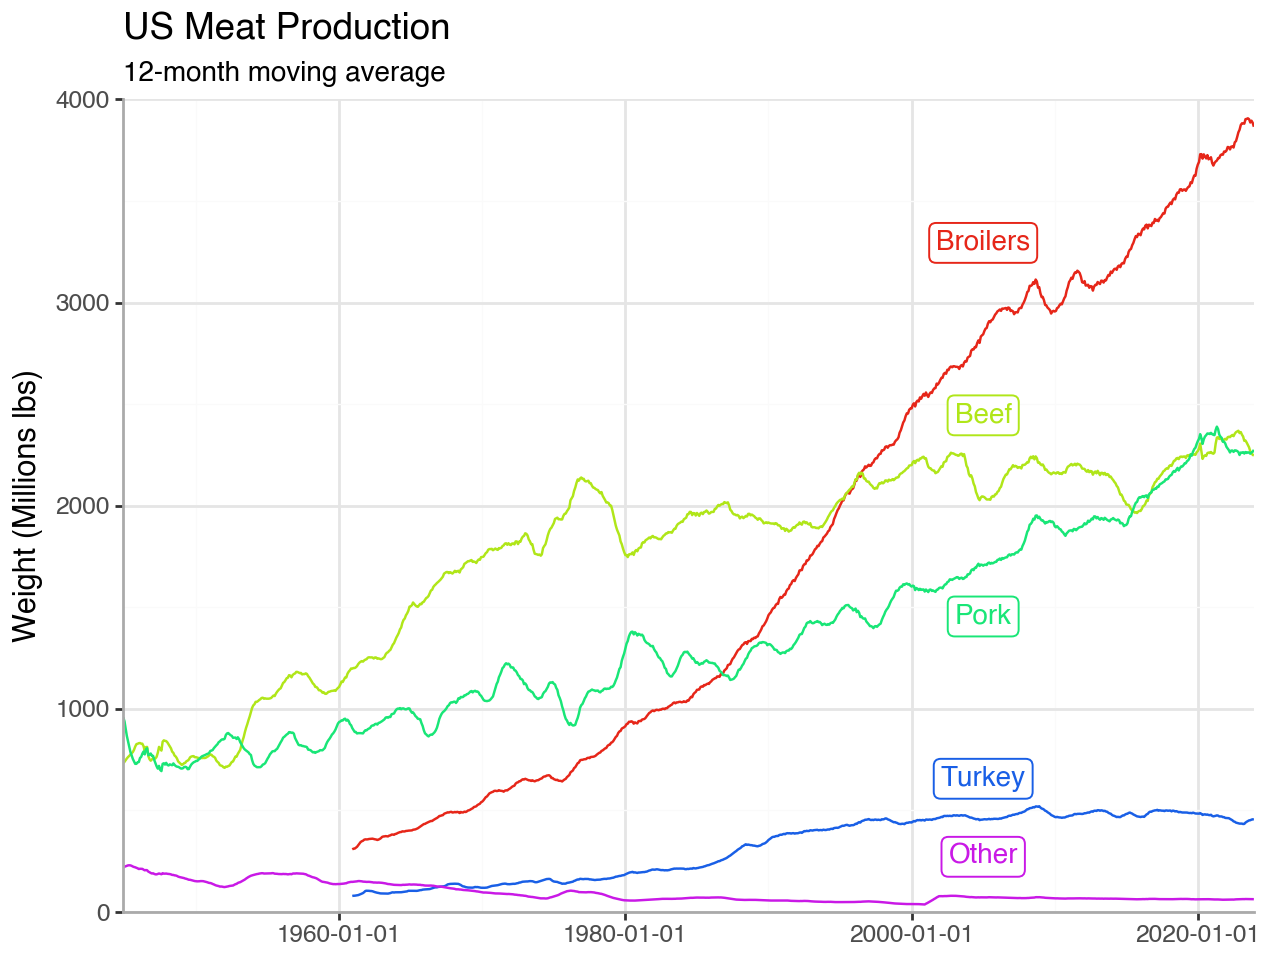

In [15]:
(
    p9.ggplot(meat_simple, p9.aes(x='date', y='weight_rolling', color='meat_type'))
    + p9.geom_line()
    + p9.labs(
        title="US Meat Production", 
        subtitle="12-month moving average", 
        x="", 
        y="Weight (Millions lbs)"
    )
    + p9.scale_colour_discrete(
        s=0.8,
        l=0.5,
        guide=None
        
    )
    + p9.geom_label(
        data=line_label,
        mapping=p9.aes(label='meat_label'),
        nudge_y=200,
        size=10
    )
    + p9.scale_y_continuous(limits=(0, 4000), expand=(0,0))
    + p9.scale_x_date(expand=(0,0))
    + p9.theme_bw()
    + p9.theme(
        panel_border=p9.element_blank(), 
        axis_line=p9.element_line(size=1, color='#AAAAAA'),
        plot_subtitle=p9.element_text(size=10)
    )
)

This last example completely eliminated the need for our original problem (turning the meat into a category with some order, to force the legend to have a sensible ordering). Note that if we pivot to something like facets, the ordering also follows the categorical ordering:

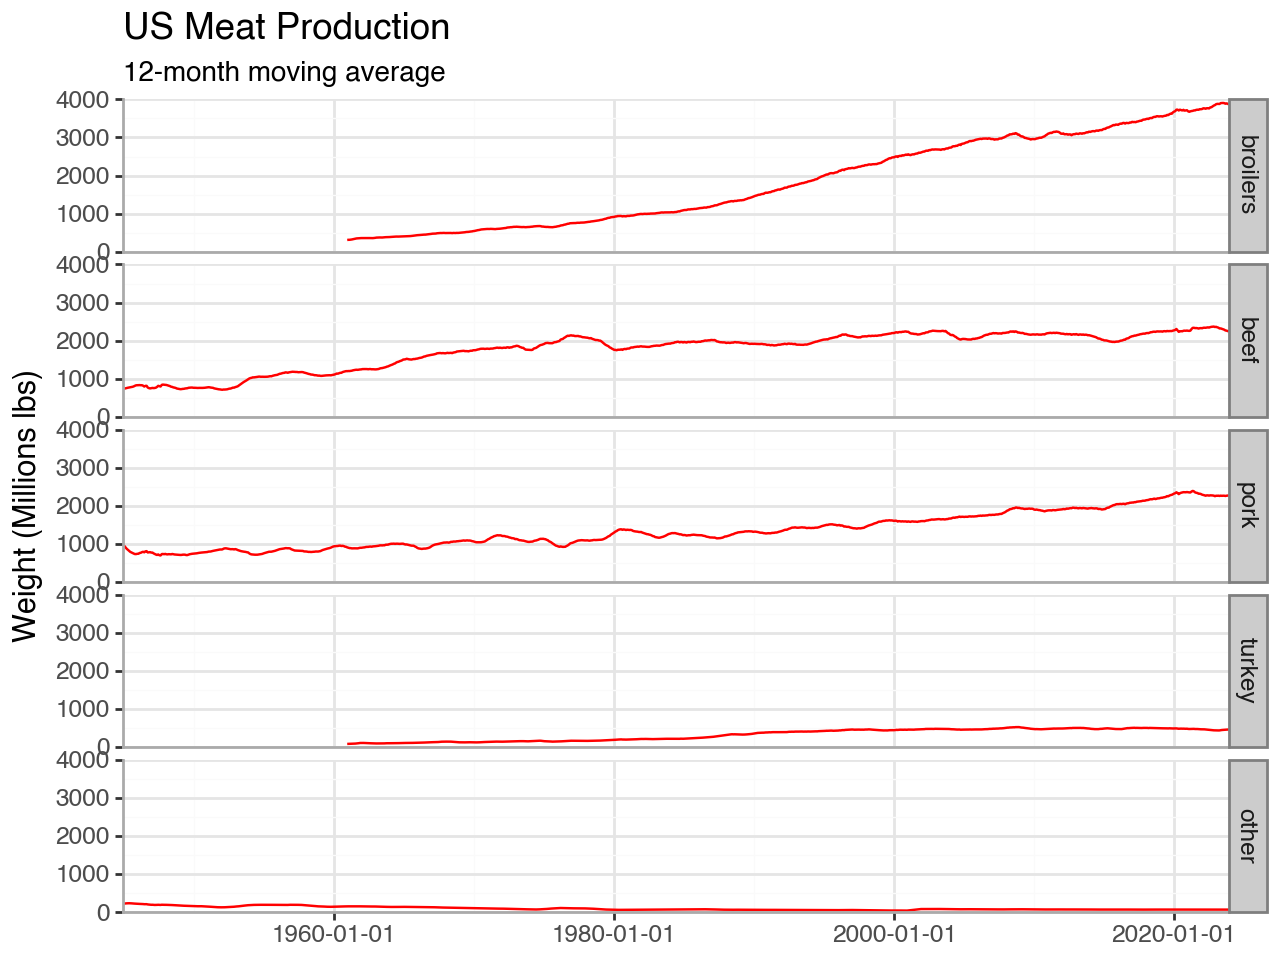

In [16]:
(
    p9.ggplot(meat_simple, p9.aes(x='date', y='weight_rolling'))
    + p9.geom_line(color='red')
    + p9.labs(
        title="US Meat Production", 
        subtitle="12-month moving average", 
        x="", 
        y="Weight (Millions lbs)"
    )
    + p9.scale_y_continuous(limits=(0, 4000), expand=(0,0))
    + p9.scale_x_date(expand=(0,0))
    + p9.theme_bw()
    + p9.theme(
        panel_border=p9.element_blank(), 
        axis_line=p9.element_line(size=1, color='#AAAAAA'),
        plot_subtitle=p9.element_text(size=10)
    )
    + p9.facet_grid('meat_type')
)

One improvement we might make to this plot: show all the other lines at the same time in grey, so we can see how a particular line compares

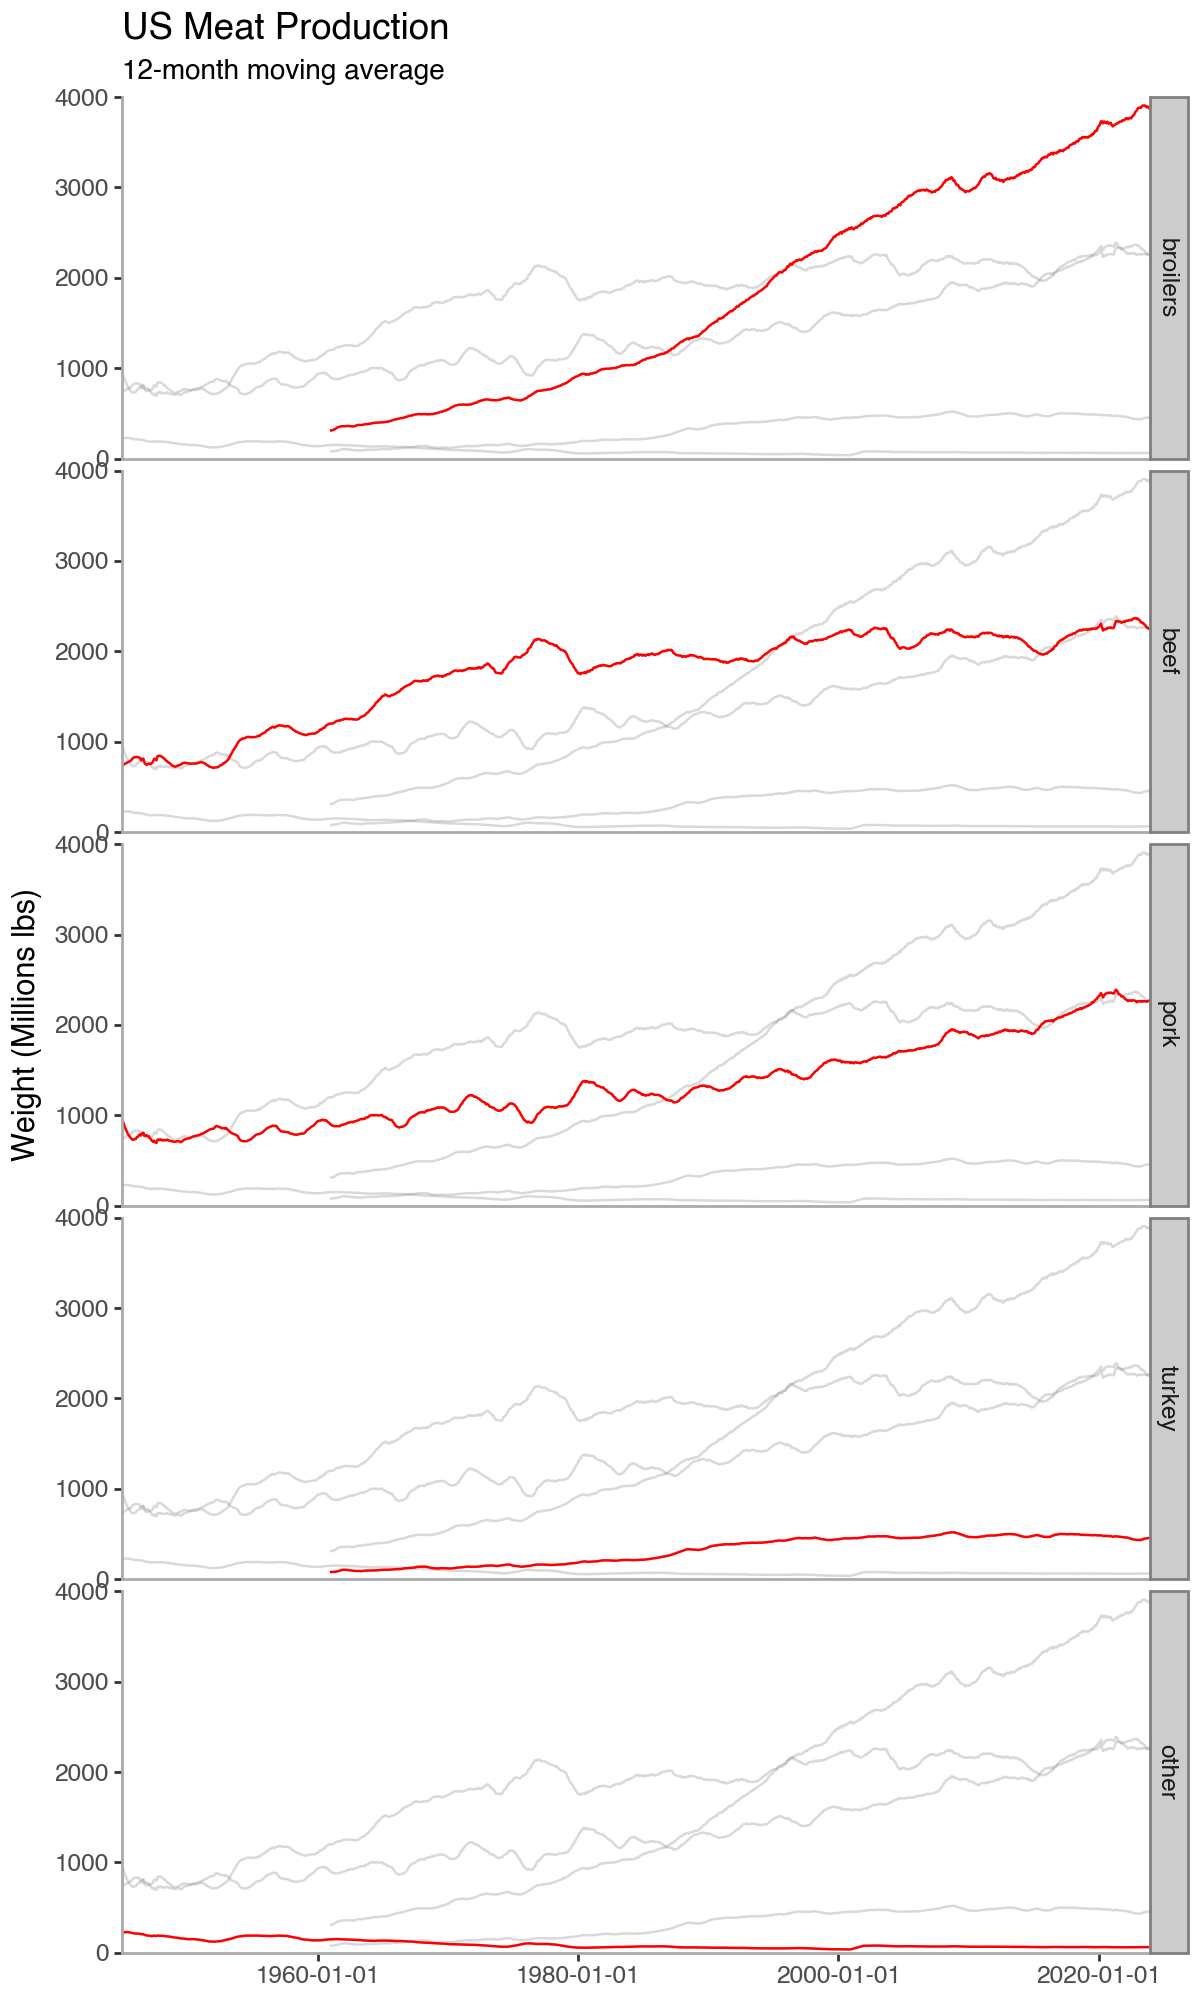

In [17]:
(
    p9.ggplot(meat_simple, p9.aes(x='date', y='weight_rolling'))
    + p9.geom_line(
        data=meat_simple.rename(columns={'meat_type': 'meat_group'}), 
        mapping=p9.aes(group='meat_group'),
        color='grey',
        alpha=0.3
    )           
    + p9.geom_line(color='red')  # add on top of grey line, but only for this facet
    + p9.labs(
        title="US Meat Production", 
        subtitle="12-month moving average", 
        x="", 
        y="Weight (Millions lbs)"
    )
    + p9.scale_y_continuous(limits=(0, 4000), expand=(0,0))
    + p9.scale_x_date(expand=(0,0))
    + p9.theme_bw()
    + p9.theme(
        panel_border=p9.element_blank(), 
        axis_line=p9.element_line(size=1, color='#AAAAAA'),
        plot_subtitle=p9.element_text(size=10),
        panel_grid=p9.element_blank(),
        figure_size=(6, 10)
    )
    + p9.facet_grid('meat_type')
)